# Assignment 5: Randomization test 2
## Learning Outcomes
We will continue our last homework on the use of randomization and Monte-Carlo simulation tests to determine whether a specific effect is statistically significant. Randomization and simulation tests are universal and powerful way to do this, and form an essential part of the toolkit of any Data Scientist. 
## Problem Description
In Task 1 & 2, we continue with the movie dataset. The first two task build on the last homework and run randomization tests with two new test statistics. You should re-use the randomization test function that you wrote for the last homework – but the new modified version needs to be included in the submission. In Task 3 you are asked to program a simple monte-Carlo simulation test.  
## Preliminaries
Set up the environment by importing pandas, numpy, and matplotlib. Load the movie data set into a pandas data frame. **IMPORTANT: Download and used the new movie data set that comes with this assignment on OWL**. 

In [1]:
import matplotlib
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import scipy.stats as stats

D = pd.read_csv('movieDataset.csv')

## TASK 1: Chi-square test of independence (40pts)
To test whether two discrete variables interact with each other, you can perform the Chi-sqaure test. The Chi-square statistic measures the deviation of the observed cell counts in a contingency table to the expected counts (see lecture).  
### Question 1.1: Null-hypothesis (5pts)
We want to test the hypothesis that there is a systematic relationship between director Gender and film genre. Please formulate the corresponding Null-hypothesis and Alternative hypothesis, and spell out what they predict in terms of the observed and expected cell counts.

Null-hypothesis: film genre is independent of director Gender. The Null-hypothesis predicts that the observed cell counts do not differ (significantly) from the cells counts we would expect under independence.

Alternative hypothesis: film genre and director Gender are dependent. The Alternative hypothesis predicts that the observed cell counts will differ from the cells counts we would expect under independence.

### Question 1.2: Expected frequencies (10pts)
From the table of the observed frequencies of genre / director Gender, generate a table that shows the expected frequencies if genre and gender were independent. The Marginal counts in the table should stay unchanged. 

In [13]:
#Solution 1: For next loop with indexing in Numpy array 
# https://docs.scipy.org/doc/numpy/reference/arrays.indexing.html
# Page 86-89 in Python 4 Data analysis, first edition 
observed = pd.crosstab(D.genre,D.dirGender,margins=False)
observed = np.array(observed) # Make into a np-array
siz = observed.shape
expected = np.array(observed,dtype = 'float64')
for i in range(0,siz[0]):
    for j in range(0,siz[1]):
        expected[i,j]=sum(observed[i,...])*sum(observed[...,j])/sum(sum(observed))
expected 

array([[ 8.436, 48.564],
       [ 9.472, 54.528],
       [ 7.104, 40.896],
       [ 5.328, 30.672],
       [ 6.66 , 38.34 ]])

In [14]:
#Solution 2: For next loop with indexing in Pandas Data frame  
# 
observed = pd.crosstab(D.genre,D.dirGender,margins=False)
siz = observed.shape
expected = np.array(observed,dtype = 'float64')
for i in range(0,siz[0]):
    for j in range(0,siz[1]):
        expected[i,j]=sum(observed.iloc[i,:])*sum(observed.iloc[:,j])/sum(sum(np.array(observed)))
expected 


array([[ 8.436, 48.564],
       [ 9.472, 54.528],
       [ 7.104, 40.896],
       [ 5.328, 30.672],
       [ 6.66 , 38.34 ]])

In [15]:
# Solution 3: Do it over outer product and pandas 
observed = pd.crosstab(D.genre,D.dirGender,margins=True)
expected = np.outer(observed["All"][0:-1], observed.loc["All"][0:-1]) /observed['All']['All']
expected 

array([[ 8.436, 48.564],
       [ 9.472, 54.528],
       [ 7.104, 40.896],
       [ 5.328, 30.672],
       [ 6.66 , 38.34 ]])

In [7]:
# Optional addition: Transform the expected table into a Data frame
observed = pd.crosstab(D.genre,D.dirGender,margins=False)
expected = pd.DataFrame(expected)
expected.columns = observed.columns
expected.index = observed.index
expected

dirGender,female,male
genre,,
action,8.436,48.564
adventure,9.472,54.528
comedy,7.104,40.896
drama,5.328,30.672
other,6.660,38.340


### Question 1.3: Chi-square (10pts)
Create a function that takes the data frame as input and calculates a statistics of the overall deviation between expected and observed frequencies: 
$χ^2 = \sum_i(O_i-E_i)^2/E_i)$ 

Where $O_i$ is the observed frequency for cell $i$, $E_i$ is the expected frequency for cell $i$, assuming independence of gender and genre. The sum is to be taken over all 10 cells. This test-statistic is called the Chi-square test of independence.

The function should take a data frame and return the Chi-square value. Make sure that the function performs all the required computations - it should work without you having to run the code from Question #2 first. 

Report the value of this statistic for the real data. 

Extra challenge: Make your code more flexible by not always using ``genre`` and ``dirGender`` to make the crosstab, but by providing the name of the row and column variable as an input (not required for full points).


In [3]:
# A concise function with flexible input arguments 
def calcX2(D,rows='genre',cols='dirGender'):
    observed = pd.crosstab(D[rows],D[cols], margins=True)
    expected = np.outer(observed["All"][0:-1], observed.loc["All"][0:-1]) /observed['All']['All']
    observed = pd.crosstab(D[rows],D[cols],margins=False)
    return sum(sum((observed.values-expected)**2/expected))

calcX2(D)

8.552102881235573

In [8]:
# A not-so elegant soltion, that also works
def calcX2(df):
    table = pd.crosstab(df['genre'], df['dirGender'], margins = True)

    ## calculate the expected values under the null hypothesis that the director gender is independent of the movie genre
    (r, c) = table.shape
    expected = np.zeros((r-1, c-1))
    for i in range(r-1):
        for j in range(c-1):
            expected[i, j] =  (table.iloc[i].iloc[-1] * table.iloc[-1].iloc[j])/table['All']['All']
    ## converting the contingency table to a numpy array to be used in element-wise calculation of the X2
        
    observed = np.array(pd.crosstab(df['genre'], df['dirGender']))

    X2 = sum(sum(((observed - expected)**2)/expected))

    return X2


calcX2(D)

8.552102881235573

### Question 1.4: Randomization with flexible input arguments (5pts)
Rewrite the randomization function from the last homework (Question 2.2), so it it becomes more versatile by adding additional input arguments that determines the behavior of the routine. 

- The first argument should still be a dataframe (as before)
- The second input argument should be a function that computes the test statistics. All test-statistic functions are assumed to take the data frame as the first and only input. 
- The third input argument is the name of the dataframe column that is being shuffled. 
- An optional input argument: the number of iterations (default=500)
- An optional input argument: the number of sides of the test (1 or 2; default = 1). If the test is two-sided, then count the number of cases where the absolute value of the test statistic (np.abolute) is larger or equal to the real test statistic.
- An optional input argument: The number of bins for plotting the histogram 


In [10]:
# Helper function: 
def randomize_column(df,colname):
    df_copy = df.copy()
    var = df_copy[colname].values
    np.random.shuffle(var)
    df_copy[colname]=var
    return df_copy

# Randomization test function 
def randomization_test(D,fcn,shuffle,numIterations=500,sides=1, nbins = 10):    
    listOfTS =  np.array(range(numIterations),dtype = 'float64')
    for i in range(numIterations):
        #1. Randomly shuffle the data 
        S= randomize_column(D,shuffle)         
        #2. Calculate test statistics 
        listOfTS[i] = fcn(S)

    # 3. Calculate the real test statistic 
    realTS = fcn(D)

    # 4. Plot a histogram of the 
    plt.hist(listOfTS,bins= nbins)
    plt.axvline(x=realTS, color='k')
    
    # 5. determine p-value (one sided) with rejection region above the threshold 
    if sides==1: 
        p=sum(listOfTS>=realTS)/len(listOfTS)
    # 5. determine p-value (two sided) with rejection region outside the threshold 
    
    
    if sides==2:
        plt.axvline(x=-realTS, color='r')
        p=sum(np.absolute(listOfTS)>=np.absolute(realTS))/len(listOfTS)
    print(' P-value of the randomisation test is p= ',p)
    return p

### Question 1.5: Randomization test (5pts)
Perform a randomization test for the Chi-square test of independence. Your function should plot the histogram and report the p-value.

 P-value of the randomisation test is p=  0.0756


0.0756

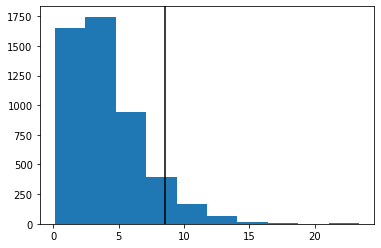

In [11]:
randomization_test(D,calcX2,shuffle='dirGender',numIterations=5000, nbins = 10)

### Question 1.6: Conclusion (5pts)
Written response: Based on the results, what can you conclude from this test? 

> Based on the p-value we cannot reject the null-hypothesis that gender and genre are independent.

# TASK 2: Randomization test for mean differences (25pts)
In this task we will test the hypothesis that male and female directors differ in their annual income. Note that the hypothesis is undirected, meaning it could mean either that men earn more than women, or that women earn more than men.

### Question 2.1: Null hypothesis (5pts)
Formulate the Null-hypothesis. 

> The corresponding Null-hypothesis is that the mean annual income for men and women directors is identical 

### Question 2.2: Difference of means (8pts)
Write a function that calculates and returns the difference in director salaries depending on the gender (male average income – female average income). Report the value. 

In [6]:
def diffSalary(D):
    genderMeanIncome = D.groupby(['dirGender']).dirIncome.mean()
    return(genderMeanIncome[1] - genderMeanIncome[0])

diffSalary(D)

0.6390446473389162

### Question 2.3:  Randomization test (7pts)
Use your randomization test function to perform a randomization test to determine whether the reported difference is statistical significant. Plot a histogram of the null-distribution and the real value. Report the p-value for the two-sided test. 

 P-value of the randomisation test is p=  0.0026


0.0026

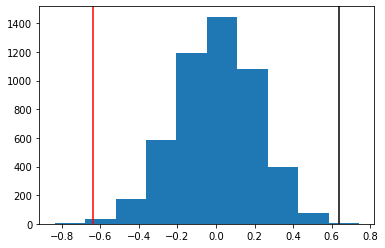

In [9]:
randomization_test(D,diffSalary,'dirGender',numIterations=5000,sides=2, nbins = 10)

### Question 2.4: Conclusion (5pts)
What do you conclude about the relationship between gender and salary? What can you conclude about the claim that there is gender discrimination in the American film industry?  


> We can conclude that in our sample gender and director Salary are highly dependent, with women directors earning a different amount from male directors. While this is suggestive of gender discrimination we cannot make a causal claim (i.e. that the women made less only because of gender), as the data is from an observational study, not an experiment. 

# Task 3: Monte-Carlo simulation test (35pt)
People providing an organ for donation sometimes seek help from a medical consultant. These consultants assist the patient in all aspects of the surgery. Patients might choose a consultant based in part on the historical complication rate of the consultant's clients. Consultant R tries to attract patients by noting the average complication rate for liver donor surgeries in the US is about 10%, but her clients have had only 3 complications in the 62 liver donor surgeries she has facilitated. She claims this is strong evidence that her work meaningfully contributes to reducing complications (and therefore she should be hired!).

### Question 3.1: Monte Carlo simulation (15pts)
Write a function (monteCarloSim) that simulates coin tossing. On each trial, the function should produce a specific number (N) of coin tosses and record the number of successes (heads). It should repeat this experiment numIter number of times. The inputs to the function should be a) probability of a success on each coin toss, b) the number of coin tosses per trial (N) and c) the number of trials. The function should return an np.array(range(numIter)) that holds the recorded number of heads for all trials (see lecture handout for tips).

In [11]:
def monteCarloSim(p,N,numIter):
    numHeads = np.array(range(numIter),dtype = 'float64')

    for i in range(numIter):
        options = [0,1]
        probDist = [1-p,p]
        
        # Solution 1: use random choice and sum over hits 
        a=np.random.choice(options,N,p=probDist)
    
        numHeads[i]=a.sum()
        # Solution 2: Use random binomial 
        # numHeads[i]=np.random.binomial(N,p) 
    return numHeads
a=monteCarloSim(0.1,62,1000)
a

array([ 6., 10., 11.,  8.,  7.,  4.,  5.,  7., 11.,  4.,  6.,  7.,  5.,
        9.,  6.,  9.,  6.,  7.,  8.,  4.,  4.,  7.,  9.,  2., 11.,  6.,
       10.,  5.,  5.,  9.,  8.,  5.,  3.,  5.,  9.,  8.,  4.,  9.,  5.,
       10.,  7., 10.,  6.,  7.,  7.,  9.,  6.,  5.,  8.,  4.,  7.,  5.,
        7.,  4.,  5.,  4.,  5.,  6.,  9.,  4.,  4.,  7.,  8.,  4.,  5.,
        9.,  5.,  5.,  5.,  4.,  7.,  7., 10.,  9.,  4.,  4.,  5.,  7.,
        3.,  7.,  3.,  4.,  4.,  6.,  6.,  6.,  6.,  5.,  7.,  9., 10.,
        6.,  4.,  7.,  8.,  8.,  9.,  5.,  4.,  3.,  8.,  6., 11.,  2.,
        7., 11.,  9.,  5.,  8.,  3.,  3.,  7.,  8.,  8.,  6.,  4.,  7.,
        4.,  8.,  9.,  2., 11.,  7.,  9.,  3.,  3.,  8.,  8.,  9.,  9.,
        9.,  6., 11.,  4.,  9.,  8.,  8.,  8.,  2.,  4.,  5.,  6.,  5.,
        6.,  9., 10.,  8.,  7.,  4.,  6.,  6.,  6.,  6.,  5.,  8.,  6.,
        4.,  4.,  6.,  6.,  6.,  7.,  5.,  3.,  8.,  5.,  5.,  9.,  5.,
        7.,  6.,  7.,  1., 13.,  8.,  8.,  6.,  8., 10., 11.,  6

### Question 3.2: Monte Carlo Test (15pts)
Write a function (monteCarloTest) that uses monteCarloSim (Question 1) to simulate 2000 trials of a N coin tosses. 
The function should take as input arguments: 

* `H0prob`: The probability of heads under the Null hypothesis
* `N`: The number of coin throws per trial 
* `numHeads`: The number of observed coin tosses.  

After getting the simulation result from `monteCarloSim`, the function should plot a histogram of the recorded number of heads, and mark the real measured number (`numHeads`) with a vertical line. The function should print out the probability that the simulated number of heads is smaller than or equal to the measured number of heads.  

Use the function to evaluate the medical advisor example from the lecture: Determine the probability to get 3 complications in 62 cases if the probability of a complication in the population is known to be 10%. 

In [12]:
def monteCarloTest(H0prob,N,numHeads):
    sim = monteCarloSim(H0prob,N,2000)
    plt.hist(sim,bins=range(20),align='left')
    plt.axvline(x=numHeads, color='k')
    p=sum(sim<=numHeads)/len(sim)
    print('P-value of the randomisation test is p=',p)
    return p


P-value of the randomisation test is p= 0.1235


0.1235

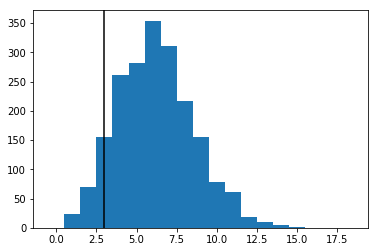

In [13]:
monteCarloTest(0.1,62,3)

### Question 3.3: Conclusion (5pts)
Written answer: What do you conclude about the claim that the work of advisor R is lowering complication rates?

> The probability of getting 3 or less complication funder the Null-hypothesis that p=0.1 is approximately p=0.12. So we cannot reject the null-hypothesis that the medical advisor does not have any beneficial effect on the complication rate. Thus there is no significant statistical evidence that would justify the claim that the advisor is lowering complication rates. 